# Cesta do útrob rozhodovacího stromu

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

Na úplně prvním běhu tohoto kurzu jsem vznesla požadavek *"nakresli mi rozhodovací strom"*. Roman pohotově vymyslel následující úlohu. Máme sadu vozidel, u kterých známe váhu a počet kol. Úkolem je vytvořit rozhodovací strom, který bude rozhodovat, zda je na vozidlo potřeba řidičský průkaz nebo není. 

Na této jednoduché úloze si budeme demonstrovat, jak rozhodovací strom funguje a co všechno z něj lze vyčíst. 

Začneme tím, že si vytvoříme jednoduchý DataFrame obsahující náš vozový park:

In [2]:
vozidla = [
    {"jmeno": "jednokolka", "vaha": 20, "kola": 1, "ridicak": False},
    {"jmeno": "tříkolka", "vaha": 10, "kola": 3, "ridicak": False},
    {"jmeno": "odrážedlo", "vaha": 5, "kola": 4, "ridicak": False},
    {"jmeno": "inline brusle", "vaha": 1, "kola": 8, "ridicak": False},
    {"jmeno": "vyložený paleťák", "vaha": 140, "kola": 8, "ridicak": False},
    {"jmeno": "naložený paleťák", "vaha": 1140, "kola": 8, "ridicak": False},
    {"jmeno": "auto", "vaha": 2000, "kola": 4, "ridicak": True},
    {"jmeno": "velorex", "vaha": 365, "kola": 3, "ridicak": True},
    {"jmeno": "motorka", "vaha": 200, "kola": 2, "ridicak": True},
    {"jmeno": "autobus", "vaha": 18000, "kola": 8, "ridicak": True}
]

df = pd.DataFrame(vozidla)
df

,jmeno,vaha,kola,ridicak
0,jednokolka,20,1,False
1,tříkolka,10,3,False
2,odrážedlo,5,4,False
3,inline brusle,1,8,False
4,vyložený paleťák,140,8,False
5,naložený paleťák,1140,8,False
6,auto,2000,4,True
7,velorex,365,3,True
8,motorka,200,2,True
9,autobus,18000,8,True


Nyní si data zobrazíme, na váhy bude lepší použít logaritmické měřítko. 

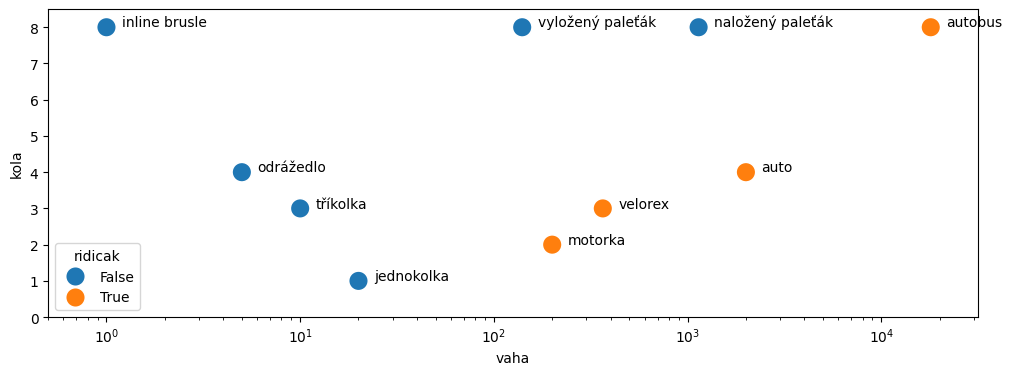

In [3]:
def show_vozovy_park(df, ax):
    ax = sns.scatterplot(data=df, x="vaha", y="kola", hue="ridicak",
                         s=200,
                         ax=ax)
    ax.set(xscale='log')
    ax.set(ylim=(0,8.5))
    ax.set(xlim=(0.5, 10**4.5))
    
    for i, row in df.iterrows():
        ax.text(1.2*row['vaha'], row['kola']+0.02, row['jmeno'])
    return ax
    
f, ax = plt.subplots(figsize=(12,4))
show_vozovy_park(df, ax);    

### Úkol 1:
Prohlédněte si obrázek a zamyslete se, jak byste data odělili sadou rovných čar. Máte možnost kreslit pouze čáry kolmé na osu x (`vaha`) nebo na osu y (`kola`), tedy např. oddělující vozidla s méně než třemi koly od vozidel s více než třemi koly, apod. 

<hr>

## Vytvoření a zobrazení stromu

Nyní vytvořme rozhodovací strom pomocí Scikit-learn třídy [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 

In [4]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [5]:
input_features = ["vaha", "kola"]
output_feature = "ridicak"
classes = ["Řidičák netřeba",  "Řidičák nutný"] #False ... řidičák netřeba, True ... řidičák nutný

In [6]:
y = df[output_feature]
X = df[input_features]

Pozn.: Tentokrát neřešíme trénovací a testovací data, jde jen o ilustrační úlohu.

In [7]:
tree = DecisionTreeClassifier()
tree.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Použijeme pomocnou funkci [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) a můžeme si strom prohlédnout:

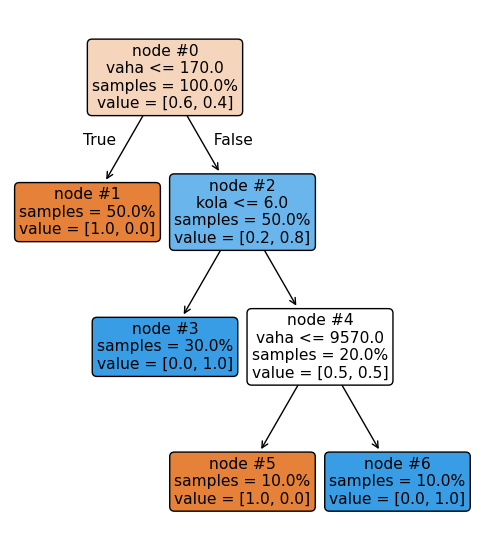

In [8]:
_, ax = plt.subplots(figsize=(6, 7))
plot_tree(tree, proportion=True, filled=True, node_ids=True, feature_names=["vaha", "kola"],
          rounded=True, impurity=False, ax=ax);

Strom na obrázku má 7 uzlů, označených `#0` až `#6`. Uzel `#0` je na vrcholu stromu a v něm rozhodování začíná. Pokud je podmínka `vaha <= 170` splněna, pokračujeme doleva (uzel `#1`), pokud není splněna, doprava (uzel `#2`).

Uzel `#1` je list stromu (nemá už žádné následníky) a jeho hodnota je `[0.0, 1.0]`, kde první číslo udává příslušnost do třídy 0 (Řidičák netřeba) a druhé číslo udává příslušnost do třídy 1 (Řidičák nutný). V tomto případě, pokud skončíme v uzlu `#1`, nepotřebujeme řidičák. 

Uzel `#2` naopak obsahuje další podmínku, podle které se rozhodujeme zda pokračujeme do doleva nebo doprava. Vždy putujeme stromem tak dlouho, dokud neskončíme v uzlu, který je listem. Tento list pak obsahuje výstup.

Teď si z původního DataFramu vyzobneme jeden řádek, třeba ten pro autobus:

In [9]:
to_classify = df.loc[df["jmeno"] == "autobus"]
to_classify

,jmeno,vaha,kola,ridicak
9,autobus,18000,8,True


Využijeme metodu stromu [decision_path](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.decision_path), které předáme náš vstup (`input_sample`), tedy váhu a počet kol autobusu, a která nám vrátí pole nul a jedniček stejné délky jako je počet uzlů stromu. Uzly, které mají indikátor 1 jsou navštíveny při cestě stromem, přes uzly které mají indicátor 0 náš autobus neprochází.

In [10]:
input_sample = to_classify[input_features] 
# metoda bere na vstup více vzorů (matice N x počet vstupů) a vrací matici N x počet uzlů stromu
# matice je reprezentovaná řídkou maticí, proto ji převedeme pomocí .toarray() 
# v našem případě jsme předali jeden vstupní vzorek, musíme tedy vyzobnout první řádek pomocí [0]
node_indicators = tree.decision_path(input_sample).toarray()[0] 
node_indicators

array([1, 0, 1, 0, 1, 0, 1])

Teď už si jen vyzobněme  čísla uzlů, které mají hodnotu indikátoru 1 a vypišme si cestu stromem:

In [11]:
node_ids = [i for i, indicator in enumerate(node_indicators) if indicator]

print(" --> ".join(map(lambda x: f"#{x}", node_ids)))

#0 --> #2 --> #4 --> #6


Autobus tedy začíná v uzlu 0, který je vrcholem stromu a postupně postupuje stromem dle rozhodovacích podmínek v uzlech až skončí v uzlu č. 6, který je listem stromu a obsahuje výslednou klasifikaci (ověř si na obrázku, že je tomu opravdu tak).

Číslo listu, kde vzorek skončí, můžeme také získat pomocí metody apply:

In [12]:
leaf_id = tree.apply(input_sample)
# metoda bere na vstup více vzorů (matice N x počet vstupů) a vrací číslo listu pro každý z těchto vzorů  (vektor N čísel)
# v našem případě jsme předali jeden vstupní vzorek, musíme tedy vyzobnout první číslo
leaf_id[0]

np.int64(6)

Teď si vypišme podrobněji cestu našeho autobusu stromem: 

In [13]:
print(f"Pravidla pro predikci vzorku '{to_classify.iloc[0]['jmeno']}':\n")

feature = tree.tree_.feature # index vstupní proměnné, která se používá v daném uzlu při rozhodování kam dál 
threshold = tree.tree_.threshold # threshold daného uzlu 
values = tree.tree_.value # pro každý uzel pole výstupů pro každou třídu 

for node_id in node_ids:
    if  leaf_id == node_id:
        print(f"output node   #{node_id}: ".ljust(50), end=" ") 
    else: 
        # uzel realizuje podmínku feature[node_id] <= threshold[node_id] 
        if input_sample.iloc[0, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print((f"decision node #{node_id} : ({input_sample.columns[feature[node_id]]} = {input_sample.iloc[0, feature[node_id]]}) " + 
              f"{threshold_sign} {threshold[node_id]}").ljust(50), end=" ")
    # teď vypišme výstupy uzlu (lze i u vnitřních uzlů, hodnota ještě není finální)    
    print(f"{classes[0]}: {100*values[node_id][0][0]:3.0f}%, {classes[1]}: {100*values[node_id][0][1]:3.0f}%")
print()

Pravidla pro predikci vzorku 'autobus':

decision node #0 : (vaha = 18000) > 170.0          Řidičák netřeba:  60%, Řidičák nutný:  40%
decision node #2 : (kola = 8) > 6.0                Řidičák netřeba:  20%, Řidičák nutný:  80%
decision node #4 : (vaha = 18000) > 9570.0         Řidičák netřeba:  50%, Řidičák nutný:  50%
output node   #6:                                  Řidičák netřeba:   0%, Řidičák nutný: 100%



### Úkol 2: 
Vraťte se k buňce, kde definujeme jednořádkový DataFrame `to_classify` a zkuste vybrat jiné vozidlo. Pak se podívejte, jak toto vozidlo putuje rozhodovacím stromem.

<hr>

## Zobrazení rozhodovací hranice ve vstupním prostoru

Na závěr si ještě prohlédneme, jak vypadá vstupní prostor a rozhodovací hranice v něm. Použijeme barevnou paletu `plt.cm.coolwarm`, tedy záporná čísla nám půjdou do studených barev (modrá) a kladná čísla do teplých barev (červená). Červená nám tedy indikuje potřebu řidičáku.

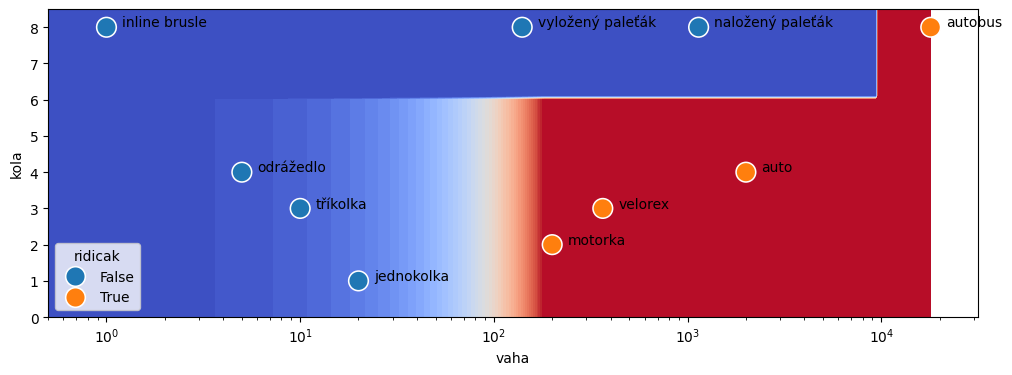

In [14]:
from sklearn.inspection import DecisionBoundaryDisplay
f, ax = plt.subplots(figsize=(12,4))
def show_decision_boundary(model, X, ax):
    DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        cmap=plt.cm.coolwarm,
        response_method="predict",
        xlabel="vaha",
        ylabel="kola",
        levels=50,
        eps=1,
        ax=ax,
    )
    ax = show_vozovy_park(df, ax)
    return ax
ax = show_decision_boundary(tree, X, ax)

### Úkol 3: 
Na obrázku máme třídy oddělené schodovitou čarou. Dovedli byste třídy oddělit jednou čarou? Nemusí být tentokrát kolmá na osu. 

<hr>

# Lineární klasifikace

Na obrázku nahoře lze oddělit vozidla bez řídičáku a vozidla se řidičákem přímkou. Klasifikaci proto můžeme zvládnout i lineárním modelem, jen pozor potřebujeme logaritmus váhy, protože na obrázku máme logaritmické měřítko.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer

Vytvoříme si transformátor, který nám sloupeček `vaha` převede na logaritmus. Ostatní sloupečky nechá jak jsou. Pro jednoduchost a snadné zobrazování nebudeme data škálovat.

In [16]:
import numpy as np
vaha_to_log = make_column_transformer(
    (FunctionTransformer(np.log), ["vaha"]),
    remainder="passthrough"
)

Transformátor spolu s lineární regresí spojíme do jednoho modelu pomocí `pipeline`.

In [17]:
model = Pipeline([("transform", vaha_to_log),  ("model", LinearRegression())])
model.fit(X, y)

,steps,"[('transform', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('functiontransformer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [18]:
pred = model.predict(X)
pred

array([ 0.43319275,  0.20806847,  0.05020376, -0.42921315,  0.21673647,
        0.49086547,  0.83338148,  0.6782932 ,  0.66691691,  0.85155464])

Model se učil na datech, kde `False` neboli `0` znamenalo, že řidičák není potřeba, a `True` neboli `1` znamenalo, že řidičák potřeba je. Regrese nám bude vracet hodnoty typu `float`, které můžeme interpretovat tak, že hodnoty menší než `0.5` znamenají nulu, neboli *bez řidičáku*, a hodnoty větší než `0.5` znamenají jedničku, neboli *řidičák je potřeba*.

In [19]:
df["predikce"] = pred > 0.5
df

,jmeno,vaha,kola,ridicak,predikce
0,jednokolka,20,1,False,False
1,tříkolka,10,3,False,False
2,odrážedlo,5,4,False,False
3,inline brusle,1,8,False,False
4,vyložený paleťák,140,8,False,False
5,naložený paleťák,1140,8,False,False
6,auto,2000,4,True,True
7,velorex,365,3,True,True
8,motorka,200,2,True,True
9,autobus,18000,8,True,True


Na tabulce vidíme, že regrese zvládá oddělit vozidla s řidičákem a bez. Ještě si vykresleme, jak vypadá z pohledu regrese vstupní prostor.

Kromě barevné mapy si vykreslíme i čáru, zobrazující hranici tříd, tedy přímku, kde lineární regrese dává výstup `0.5`. Linární regrese počítá lineární kombinaci svých vstupů, tedy:
$$ y = w_0 \cdot V_{log} + w_1 \cdot K + b, $$
kde $V_{log}$ je logaritmus váhy vozidla, $K$ je počet kol a $w_0, w_1, b$ jsou parametry modelu.  Abychom do grafu mohli vykreslit dělící přímku, vyjádřeme si závislost váhy na počtu kol pro výstup $y = 0.5$:
$$
 V_{log} = (0.5 - w_1 \cdot K - b) / w_0.
$$
Pomocí tohoto vzorečku si můžeme nagenerovat data pro vykreslení přímky odpovídající hranici.

In [ ]:
# decision boundary display aplikovaný na celou pipeline zkresluje hranice kvůli logaritmickému měřítku a malému rozlišení
# pro větší rozlišení se to seká, logaritmické rozlišení asi neexistuje :)
# tak to pro účely obrázku obejdeme ... přidáme sloupeček vaha_log a vyzobneme linearni regresi z pipeline

In [20]:
df["vaha_log"] = np.log(df["vaha"])
X_plot = df[["vaha_log", "kola"]]
linear_model = model.named_steps["model"]
linear_model

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


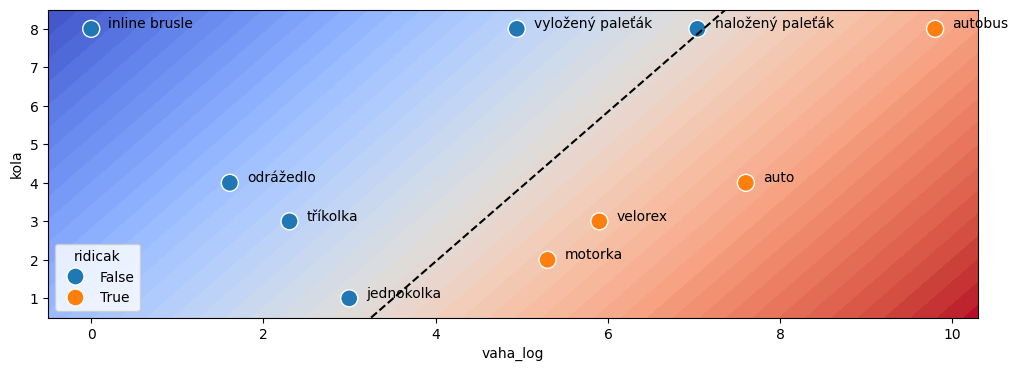

In [21]:
f, ax = plt.subplots(figsize=(12, 4))
DecisionBoundaryDisplay.from_estimator(
        linear_model,
        X_plot.values,
        cmap=plt.cm.coolwarm,
        response_method="predict",
        xlabel="vaha_log",
        ylabel="kola",
        levels=50,
        eps=0.5, ax=ax)
sns.scatterplot(data=df, x="vaha_log", y="kola", hue="ridicak", s=150)
for i, row in df.iterrows():
        ax.text(row['vaha_log']+0.2, row['kola']+0.02, row['jmeno']);


# Vykreslíme i hranici, kde lineární regrese dává na výstup přesně 0.5 
# koeficienty regrese
w = linear_model.coef_        
b = linear_model.intercept_  

# w_0 * vaha_log + w_1 * kola + b = 0.5 --> vaha_log = (0.5 - w_1 * kola - b) / w_0

y_vals = np.linspace(0.5, 8.5, 100)
# spočti y pro hranici (predikce = 0)
x_vals = (0.5 - w[1] * y_vals - b) / w[0]

# Plot
ax.plot(x_vals, y_vals, 'k--', label='Decision boundary (y=0)');


Vidíme, že naložený paleťák má sice trošku namále, ale všechna vozítka jsou správně oddělena. Pokud by se jednalo o skutečnou klasifikační úlohu s více daty, mohli bychom prahem (který je teď `0.5`) hýbat a pravidla pro klasifikaci do třídy `1` zpřísňovat nebo naopak polevovat. 
Dělící přímka by se pak na obrázku posouvala směrem do červené nebo modré.

<hr>

# Bonus: Nelineární problém

Pokud budeme mít data, kde nefunguje lineární klasifikace ani např. rozhodovací strom, můžeme sáhnout po modelech SVM (*Support Vector Machine*).

Ilustrujme si to na klasifikaci dvou spirál, umělém, ale záměrně záludném problému. Načteme a zobrazíme data.

In [22]:
df = pd.read_csv("2sp.txt", sep=r'\s+', header=None)
df.columns = ["x1", "x2", "class"]
df.sample(10)

,x1,x2,class
163,0.26907,1.41209,0.0
98,-0.65417,-3.37468,1.0
55,4.00862,-2.66292,0.0
108,-2.88065,-1.21139,1.0
111,3.00034,0.61390,0.0
175,1.04025,0.21630,0.0
49,4.99999,0.01194,0.0
20,5.43003,-2.24286,1.0
185,0.53516,-0.52545,0.0
159,-0.31687,1.53003,0.0


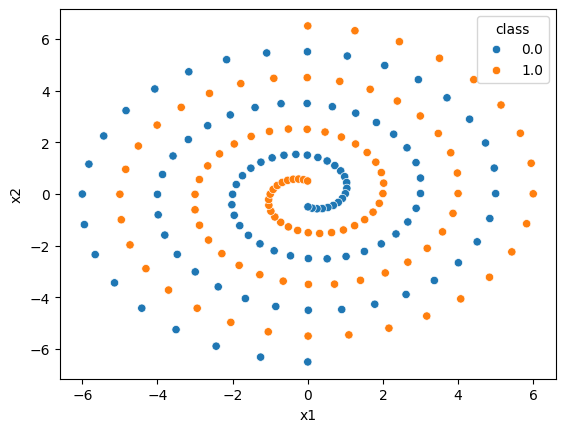

In [23]:
sns.scatterplot(data=df, x="x1", y="x2", hue="class");

Je jasné, že lineární regrese nám tady nepomůže, zkusme co udělá rozhodovací strom.

In [24]:
X = df[["x1", "x2"]]
y = df["class"]

In [25]:
model1 = DecisionTreeClassifier().fit(X, y)

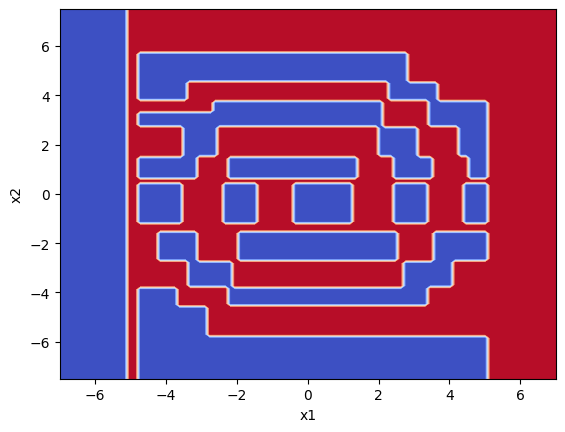

In [26]:
DecisionBoundaryDisplay.from_estimator(
    model1,
    X,
    cmap=plt.cm.coolwarm,
    response_method="predict", levels=50);

Není to úplně špatné, náznak spirál vidíme, ale ještě by se to dalo vylepšit. Podívejme se tedy, co udělá SVM Klasifikátor.

In [27]:
from sklearn.svm import SVC
model2 = SVC(kernel="rbf", gamma=0.8, C=10.0, probability=True).fit(X, y)
model2

,C,10.0
,kernel,'rbf'
,degree,3
,gamma,0.8
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


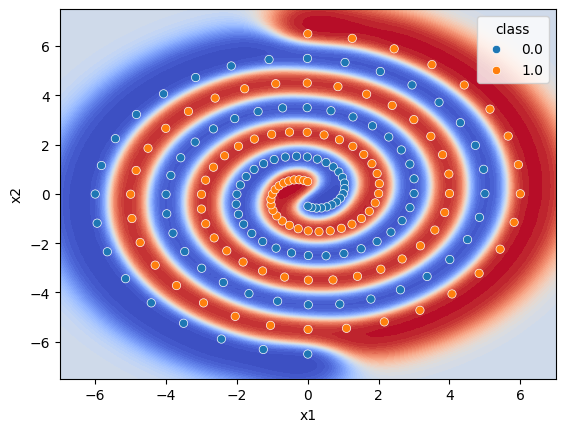

In [28]:
fig, ax = plt.subplots() 
DecisionBoundaryDisplay.from_estimator(
    model2,
    X,
    cmap=plt.cm.coolwarm,
    response_method="predict_proba", ax=ax, levels=50);
sns.scatterplot(data=df, x="x1", y="x2", hue="class", ax=ax);

To už je jiné kafe. Trošku jsme ale podváděli, a vycucali si z prstu hyper-parametry modelu. Ano, s těmi je třeba si pohrát. 

## Regularizační parametr C

Paremetr `C` potkáváme u modelů často. Je to tzv. **regularizační parametr**, čím menší hodnota, tím více regularizujeme. A zjednodušeně řečeno, čím více regularizujeme, tím je výsledná funkce modelu (pokud nemáš ráda matematiku, vzpomeň si na úvodní ilustrační příklad a nahraď slovo funkce slovem krajina) méně divoká.
Aby sis to mohla lépe představit, vytvořme si sadu obrázků pro různé hodnoty parametru C. Nalevo vidíme klasifikaci bodů v rovině, napravo funkci modelu jako 3D grafu. 

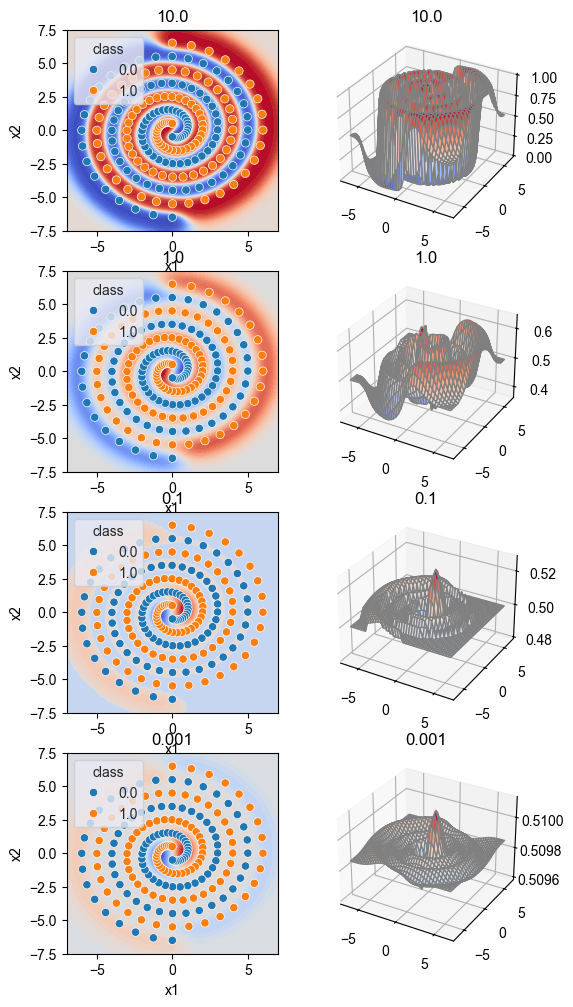

In [29]:
def plot(model, ax, C):
    sns.set_style('darkgrid')
    x_plot1 = np.linspace(-6.5, 6.5, 40)
    y_plot1 = np.linspace(-6.5, 6.5, 40)

    def comp(x1, x2):
        input_batch = pd.DataFrame()
        input_batch["x1"] = x1.ravel()
        input_batch["x2"] = x2.ravel()
        return model2.predict_proba(input_batch)[:, 1].reshape(40, 40)

    plot1, plot2 = np.meshgrid(x_plot1, y_plot1)
    plot3 = comp(plot1, plot2)

    ax.plot_surface(plot1, plot2, plot3, cmap=plt.cm.coolwarm, edgecolor='gray');
    ax.set_title(f"{C}");

def plot2(model, X, ax, C):
    DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        cmap=plt.cm.coolwarm,
        response_method="predict_proba", ax=ax, levels=50);
    sns.scatterplot(data=df, x="x1", y="x2", hue="class", ax=ax);
    ax.set_title(f"{C}");

C_values = [10.0, 1.0, 0.1, 0.001]
fig  = plt.figure(figsize=(6, len(C_values)*3))
N = len(C_values)
axs = [[] for _ in range(N)]
rows = N
cols = 2 
for i in range(N):
    axs[i].append(fig.add_subplot(rows, cols, i*2+1))
    axs[i].append(fig.add_subplot(rows, cols, i*2+2, projection='3d'))

for i, C in enumerate(C_values): 
    model2 = SVC(kernel="rbf", gamma=0.8, C=C, probability=True).fit(X, y)
    plot(model2, axs[i][1], C)
    plot2(model2, X, axs[i][0], C)
